In [ ]:
import numpy as np

from keras.layers import Dense, Embedding, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import RMSprop

#Import another jupyter notebook with attention mechanism
import import_ipynb
from AttentionLayer import *
from Productive_CrossValidation_inclTest import *
from Productive_Data_getTrainTest import reyesAll

In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/00_basic_reyes/'

In [4]:
#Load necessary data
train_data, train_labels_binary, train_labels_multy, test_data, test_labels_binary, test_labels_multy, word_index, MAX_SEQUENCE_LENGTH = reyesAll()

In [5]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\schok\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

## Modelarchitecture

In [7]:
#Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 64
softmax = True
optimizer = RMSprop(lr=0.001, rho = 0.9, epsilon = 0.0000001)
lossfunction ='binary_crossentropy'
lossfunction_multy = 'categorical_crossentropy'

In [8]:
#Networkarchitecture
wv_layer = Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True)

#Input Layer
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Embedding Layer
embedded_sequences = wv_layer(comment_input)

#LSTM Layer
x = LSTM(400, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(embedded_sequences)

#Attention Layer
x = Attention()(x)

#Dropout Layer
x = Dropout(0.2)(x)

#Dense Layer
x = Dense(400, activation="relu")(x)

#Output (Dense) Layer
preds_binary = Dense(2, activation='softmax')(x)
preds_multy = Dense(4, activation='softmax')(x)

# build the model
# Binary classification ironic vs. not-ironic for all data
model_binary = Model(inputs=[comment_input], outputs=preds_binary)

#Multy-class classification (irony, education, humor, politics)
model_multy = Model(inputs=[comment_input], outputs=preds_multy)

W0808 16:42:30.413171  1040 deprecation_wrapper.py:119] From C:\Users\schok\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 16:42:30.413171  1040 deprecation_wrapper.py:119] From C:\Users\schok\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 16:42:30.413171  1040 deprecation_wrapper.py:119] From C:\Users\schok\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 16:42:30.428769  1040 deprecation_wrapper.py:119] From C:\Users\schok\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 16:42:30.428769  1040 deprecation_wrapper.py:119] 

## Train and Evaluate models with the heldout test data

W0808 16:42:31.177466  1040 deprecation_wrapper.py:119] From C:\Users\schok\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 16:42:31.193094  1040 deprecation.py:323] From C:\Users\schok\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


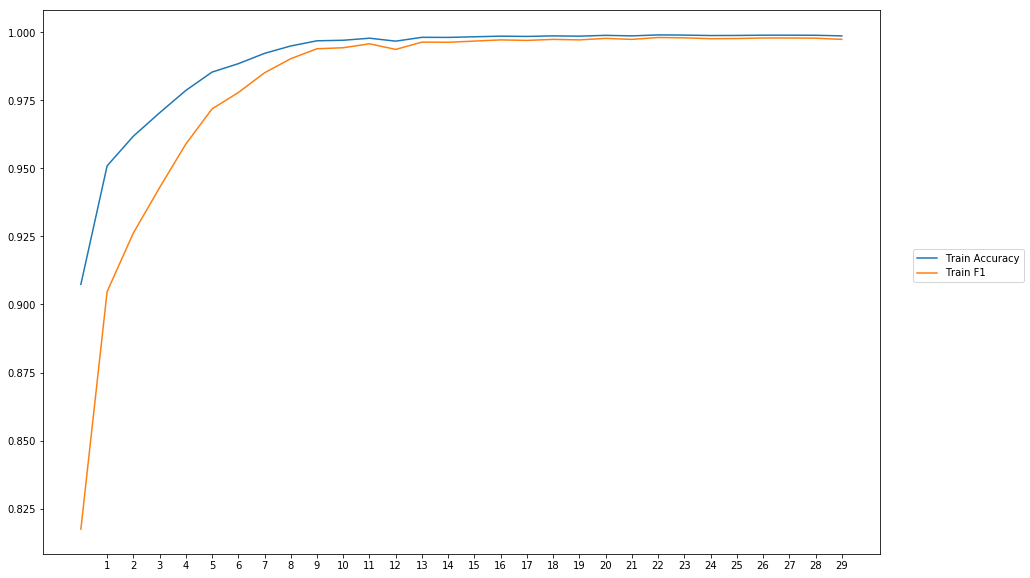


-----Test Scores----
Loss: 0.6600533596734226
Accuracy: 93.2844613169263
Precision: 88.29113923584963
Recall: 85.19083969032107
F1: 86.71328171039214


In [9]:
#binary model
train_evaluate_final_model(model_binary, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_labels_binary, test_data, test_labels_binary, softmax, outputpath, 'BasicReyes_binary')

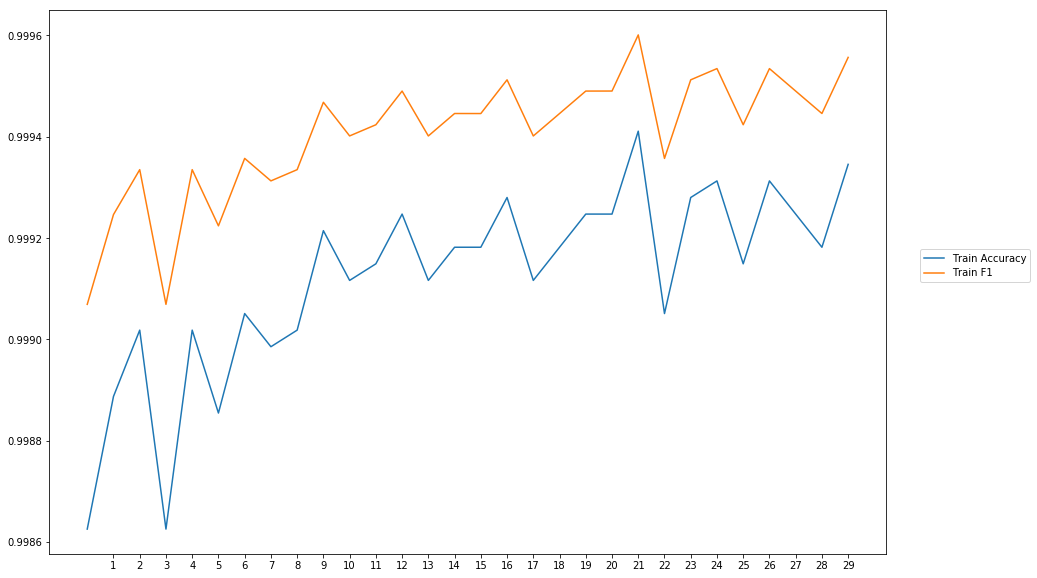


-----Test Scores----
Loss: 0.8753684440269612
Accuracy: 92.66919754518703
Precision: 96.22198119854986
Recall: 93.81388790811044
F1: 95.00267213635547


In [10]:
#Multylabelmodel
def train_evaluate_multy_model(model, nrepochs, nrbatch, optimizer, lossfunction, train_data, train_labels, test_data, test_labels, softmax, outputpath, outputname):
    import datetime
    
    seed = 7
    np.random.seed(seed)
    tf.set_random_seed(seed)
    rd.seed(seed)
    
    #needed for softmax-activation
    if softmax:
        labelstrain = to_categorical(train_labels)
    else:
        labelstrain = train_labels

    time_callback = TimeHistory() 
    
    #evaluate the positive class (=ironic data)
    precision =km.binary_precision(label=0)
    recall = km.binary_recall(label=0)
    f1 = km.f1_score(label=0)

    model.compile(loss = lossfunction,
          optimizer=optimizer,
          metrics=['accuracy', precision, recall, f1])

    #Train the model 
    hist= model.fit(train_data, labelstrain, epochs=nrepochs, batch_size=nrbatch, shuffle=True, verbose = 0, callbacks=[time_callback])

    from matplotlib import pyplot
    %matplotlib inline
    pyplot.figure(figsize=(15,10))
    pyplot.plot(hist.history['acc']) 
    pyplot.plot(hist.history['f1_score'])
    #pyplot.plot(hist.history['loss'])
    pyplot.xticks(np.arange(1,nrepochs))
    pyplot.legend(['Train Accuracy', 'Train F1', 'Validation Accuracy', 'Validation F1', 'Loss'], loc=(1.04,0.5))
    pyplot.show()

    #Store the keras model
    model.save(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+'_'+outputname+
                   '_'+'_model.h5')
    
    if softmax:
        labelstest = to_categorical(test_labels)
    else:
        labelstest = test_labels
    
    score = model.evaluate(test_data, labelstest, verbose = 0)
    
    print("\n-----Test Scores----")
    print("Loss: " + str(score[0]))
    print("Accuracy: " + str(score[1]*100))
    print("Precision: " + str(score[2]*100))
    print("Recall: " + str(score[3]*100))
    print("F1: " + str(score[4]*100))


    #stores the test results        
    f= open(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+' '+outputname+'_finaltestresults.csv','w+')
    f.write('Loss;'+str(score[0])+'\n'+
            'Accuracy;'+str(score[1])+'\n'+
            'Precision;'+str(score[2])+'\n'+
            'Recall;'+str(score[3])+'\n'+
            'F1;'+str(score[4])+'\n')
    f.close() 

train_evaluate_multy_model(model_binary, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_labels_binary, test_data, test_labels_binary, softmax, outputpath, 'BasicReyes_multy')